In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import ks_2samp, entropy
from imblearn.over_sampling import SMOTE
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

In [12]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# **shift  探究**

## **测试一下EDA步骤训练出的模型，在test2上的表现怎么样**

##  EDA步骤中用集成方法选出的最佳的特征

In [2]:
top_features = np.array(['F203', 'F18', 'F11', 'F58', 'F180', 'F137', 'F191', 'F273',
       'F275', 'F192', 'F188', 'F258', 'F281', 'F126', 'F225', 'F57',
       'F13', 'F74', 'F42', 'F1', 'F40', 'F288', 'F296', 'F128', 'F12',
       'F104', 'F164', 'F158', 'F229', 'F266', 'F289', 'F175', 'F152',
       'F151', 'F32', 'F179', 'F0', 'F165', 'F68', 'F244', 'F169', 'F66',
       'F80', 'F2', 'F184', 'F45', 'F291', 'F166', 'F298', 'F109'])

In [3]:
top_features

array(['F203', 'F18', 'F11', 'F58', 'F180', 'F137', 'F191', 'F273',
       'F275', 'F192', 'F188', 'F258', 'F281', 'F126', 'F225', 'F57',
       'F13', 'F74', 'F42', 'F1', 'F40', 'F288', 'F296', 'F128', 'F12',
       'F104', 'F164', 'F158', 'F229', 'F266', 'F289', 'F175', 'F152',
       'F151', 'F32', 'F179', 'F0', 'F165', 'F68', 'F244', 'F169', 'F66',
       'F80', 'F2', 'F184', 'F45', 'F291', 'F166', 'F298', 'F109'],
      dtype='<U4')

### 加载模型，对test2进行测试

In [4]:
xgb_loaded = XGBClassifier()
xgb_loaded.load_model("xgb_trained_model.json")

In [43]:
X = pd.read_csv("X_train.csv")
X_test2 = pd.read_csv("X_test_2.csv")
y_test2 = pd.read_csv("y_test_2_reduced.csv")["label"]
top_feature_indices = [int(f[1:]) for f in top_features]

In [45]:
X_train_selected = X.iloc[:, top_feature_indices]
X_test2_selected = X_test2.iloc[:, top_feature_indices]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_selected)
X_test2_scaled = scaler.transform(X_test2_selected)

model = XGBClassifier()
model.load_model("xgb_trained_model.json")

X_eval = X_test2_scaled[:202]
y_eval = y_test2.values.ravel()

y_pred_eval = model.predict(X_eval)

In [47]:
f1_macro = f1_score(y_eval, y_pred_eval, average='macro')
f1_macro

0.2560889750631335

In [48]:
f1_weighted = f1_score(y_eval, y_pred_eval, average='weighted')
f1_weighted

0.4308046859037736

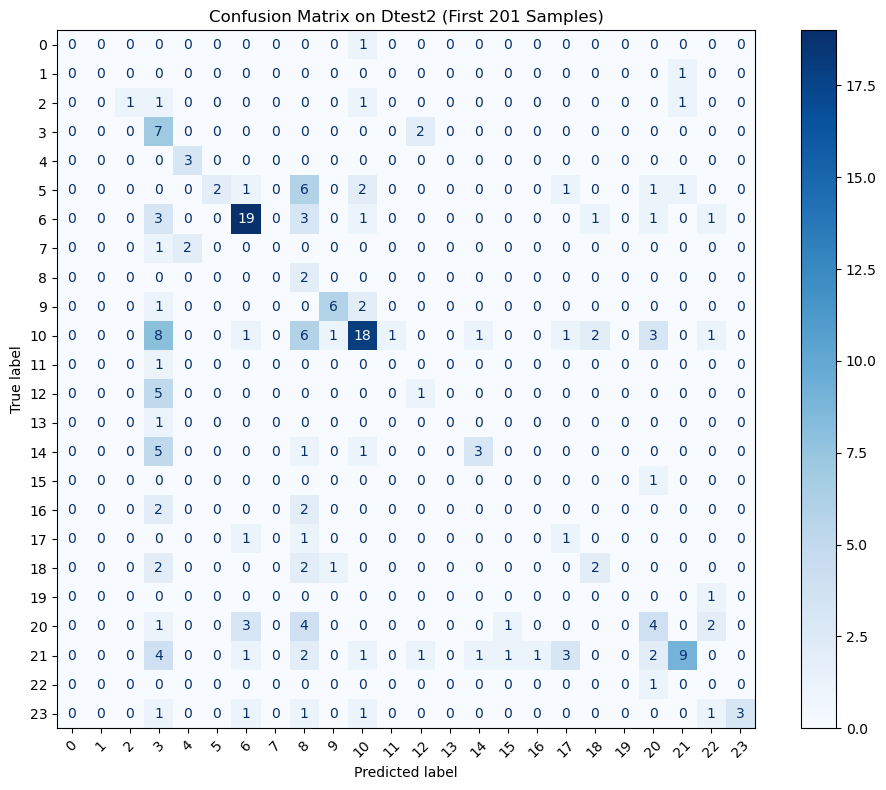

In [60]:
cm = confusion_matrix(y_eval, y_pred_eval)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on Dtest2 (First 201 Samples)")
plt.tight_layout()
plt.show()

- 根据上述的预测结果表明，模型预测的结果并不好，考虑原因是出现了偏移问题
- 下一步要分析偏移问题的种类是什么

## **识别偏移问题**

# 分布漂移问题简介（Distribution Shift）

在机器学习中，**分布漂移（Distribution Shift）** 是指模型训练所依赖的数据分布，与部署阶段实际接收到的数据分布不一致，导致模型性能下降的问题。

主要分为以下三类：

---

## 1️协变量偏移（Covariate Shift）

- 定义：特征的分布发生变化，但 **条件分布不变**
  
$$
P_{\text{train}}(x) \ne P_{\text{test}}(x), \quad \text{但} \quad P(y|x) \text{不变}
$$

- 举例：客户群体年龄分布在训练时集中在 20～30 岁，但部署后集中在 40～50 岁。

- 影响：模型面临与训练不同的输入分布，可能会误判。

---

## 2️标签偏移（Label Shift）

- 定义：标签的分布发生变化，但 **特征分布和条件分布保持不变**

$$
P_{\text{train}}(y) \ne P_{\text{test}}(y), \quad \text{但} \quad P(x|y) \text{不变}
$$

- 举例：在训练时，正负样本是 1:1，但部署后负样本激增到 1:9。

- 影响：预测倾向于频率高的标签，需重加权标签分布。

---

## 3️概念漂移（Concept Drift）

- 定义：**标签与特征的映射关系发生变化**

$$
P_{\text{train}}(y|x) \ne P_{\text{test}}(y|x)
$$

- 举例：产品评论“好轻”曾被认为是负面，但现在表示“轻便”是正面评价。

- 影响：模型失去学习到的规律，**最难应对**。

---

## 总结对比表

| 类型             | 变动部分             | 不变部分         | 应对方法                      |
|------------------|----------------------|------------------|-------------------------------|
| Covariate Shift  | $P(x)$               | $P(y|x)$         | 样本重加权、领域自适应        |
| Label Shift      | $P(y)$               | $P(x|y)$         | 标签重加权、EM 校正            |
| Concept Drift    | $P(y|x)$             | 无               | 持续学习、在线更新、重训练     |

---



## **判断是否为协变量偏移**

In [80]:
ks_results = []
kl_results = []

for col in X_train_selected.columns:
    # KS检验
    stat, p_value = ks_2samp(X_train_selected[col], X_test2_selected[col])

    # KL散度
    train_hist, bins = np.histogram(X_train_selected[col], bins=50, range=(-3, 3), density=True)
    test_hist, _ = np.histogram(X_test2_selected[col], bins=bins, density=True)
    train_hist += 1e-8
    test_hist += 1e-8
    kl_div = entropy(train_hist, test_hist)

    # 判断是否偏移：多条件组合
    is_shift = (stat > 0.1 and p_value < 0.05) or (kl_div > 0.07)

    ks_results.append({
        "feature": col,
        "KS_statistic": stat,
        "p_value": p_value,
        "KL_divergence": kl_div,
        "Shift_flag": is_shift
    })
shift_df = pd.DataFrame(ks_results).sort_values("KS_statistic", ascending=False)

print(f"{shift_df['Shift_flag'].sum()} / {len(shift_df)} 个特征存在协变量偏移")


3 / 50 个特征存在协变量偏移


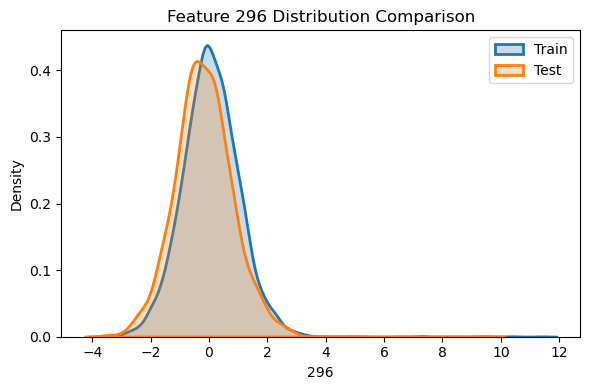

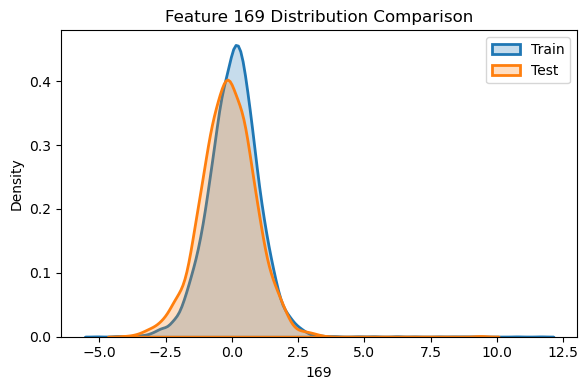

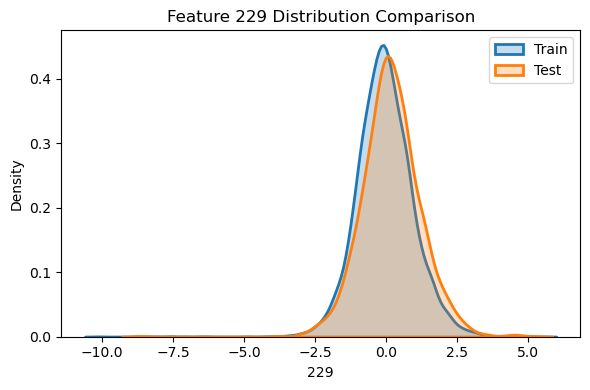

In [81]:
top_shifted_features = shift_df[shift_df["Shift_flag"] == True].head(5)["feature"].values

for feat in top_shifted_features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(X_train_selected[feat], label="Train", fill=True, linewidth=2)
    sns.kdeplot(X_test2_selected[feat], label="Test", fill=True, linewidth=2)
    plt.title(f"Feature {feat} Distribution Comparison")
    plt.xlabel(feat)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 通过上述可视化经过组合方式判断出差异最明显的三个特征编号的数据分布图比较
- train和test数据特征分布大部分重叠，基本上看不出差异
- 考虑不是协变量偏移
- 需要按顺序继续进行检测


# KS检验与KL散度：判断协变量偏移的原理解释

在实际机器学习任务中，我们常通过对比训练集与测试集特征的边缘分布 $P(x)$，来判断是否发生了协变量偏移（Covariate Shift）。其中，Kolmogorov–Smirnov检验（KS） 和 Kullback–Leibler散度（KL） 是两个常用且互补的方法。

---

## 1. Kolmogorov–Smirnov 检验（KS检验）

### 原理：

KS检验是一个非参数检验方法，用于比较两个一维连续变量是否来自同一分布。它通过比较它们的经验分布函数（Empirical CDF）之间的最大差异来得出结论。

$$
D_{n,m} = \sup_x \left| F_n(x) - G_m(x) \right|
$$

其中：

- $F_n(x)$：训练集特征的经验累积分布函数（CDF）
- $G_m(x)$：测试集特征的经验累积分布函数
- $\sup_x$：取所有 $x$ 上的最大垂直差距

### 解读：

- $D$ 越大，表示两个分布越不相似
- p-value 越小，越有信心拒绝“同分布”的假设

KS检验关注的是“最大点差异”，适合发现明显错位的特征分布。

---

## 2. Kullback–Leibler 散度（KL散度）

### 原理：

KL散度是一种衡量两个概率分布之间差异的信息论方法，定义如下：

$$
\text{KL}(P \| Q) = \sum_i P(i) \log \frac{P(i)}{Q(i)}
$$

其中：

- $P(i)$：训练集上的特征概率分布
- $Q(i)$：测试集上的特征概率分布
- 通常需要对连续特征做离散化（如使用 histogram）

### 解读：

- KL 越大，说明两个分布越不一致
- 是非对称性指标：$\text{KL}(P\|Q) \ne \text{KL}(Q\|P)$
- 对尾部、形状的微小变化非常敏感

KL散度关注的是“整体分布的信息差异”，更细腻但也更容易受异常值影响。

---

## 3. 二者对比总结

| 特性          | KS检验                             | KL散度                        |
|---------------|-------------------------------------|--------------------------------|
| 类型          | 非参数、统计检验                   | 信息论度量                    |
| 输入要求      | 连续变量的原始数值                | 离散化后的概率分布             |
| 灵敏区域      | 经验CDF的最大差异                  | 整体分布形状、尾部             |
| 是否对称      | 对称                                | 非对称                         |
| 常用于        | 判断是否来自同一分布                | 衡量分布之间的信息距离         |

---

## 4. 如何综合判断是否发生协变量偏移

单独使用 KS 检验或 KL 散度可能会存在误判或过敏感的问题，因此推荐结合两个指标进行综合判断：

- **KS 统计量 $D$**：若 $D > 0.1$，表示经验分布函数差异较大
- **p-value**：若 $p < 0.05$，在统计学上可拒绝“同分布”的假设
- **KL 散度**：若 $\text{KL} > 0.05$ 或 $\text{KL} > 0.1$，表示概率分布差异显著

建议采用如下组合判断逻辑：

$$
\text{Shift} = (D > 0.1 \land p < 0.05) \lor (\text{KL} > 0.05)
$$

即：若 KS 和 KL 中有任一显著偏移，即可认为该特征发生了协变量偏移。

此外，可视化分布（如 KDE 曲线）也是重要的直观判断方式。建议在报告中对偏移最显著的特征进行图形展示，并结合模型性能变化进一步验证是否影响了泛化能力。


### 判断是否是标签偏移

KL 散度（KL divergence）: 0.9445


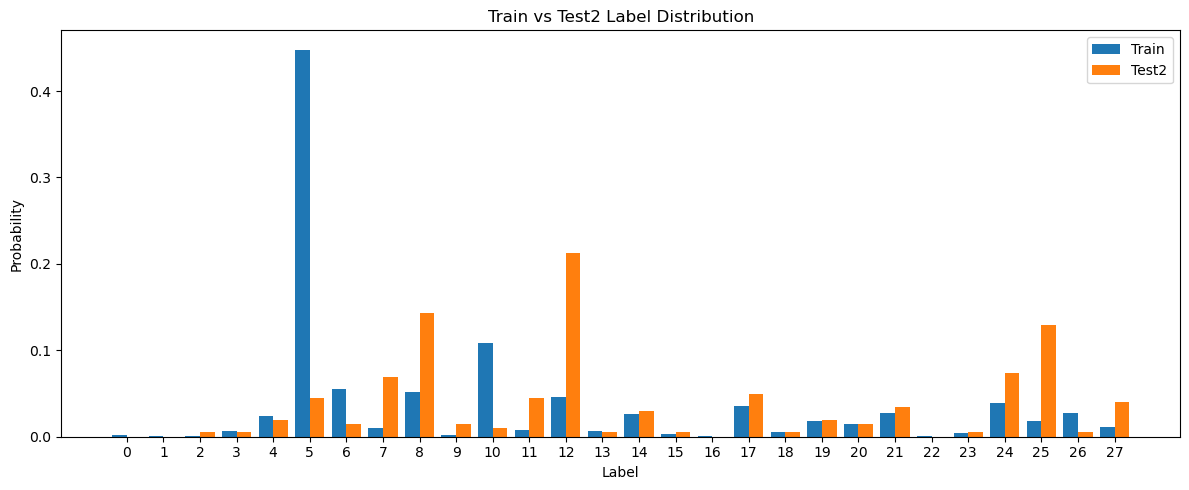

In [82]:
# 读取标签列
y_train = pd.read_csv("y_train.csv")["label"]
y_test2 = pd.read_csv("y_test_2_reduced.csv")["label"]

# 获取标签全集（可能 test2 中缺少部分标签）
all_labels = sorted(set(y_train.unique()) | set(y_test2.unique()))

# 计算标签分布（归一化频率）
train_dist = y_train.value_counts(normalize=True).sort_index()
test_dist = y_test2.value_counts(normalize=True).sort_index()

train_probs = np.array([train_dist.get(i, 0) for i in all_labels])
test_probs = np.array([test_dist.get(i, 0) for i in all_labels])

# 计算 KL 散度
kl_div = entropy(test_probs, train_probs)
print(f"KL 散度（KL divergence）: {kl_div:.4f}")

# 可视化标签分布对比
x = np.arange(len(all_labels))
plt.figure(figsize=(12, 5))
plt.bar(x - 0.2, train_probs, width=0.4, label='Train')
plt.bar(x + 0.2, test_probs, width=0.4, label='Test2')
plt.xticks(x, all_labels)
plt.xlabel("Label")
plt.ylabel("Probability")
plt.title("Train vs Test2 Label Distribution")
plt.legend()
plt.tight_layout()
plt.show()


### 标签偏移检测结果分析

我们通过对训练集和 Test2 测试集的标签分布进行比较，发现：

- KL 散度为 **0.9445**，远大于 0.1 的常规判断阈值；
- 柱状图显示多个标签的比例显著不同，例如训练集中 label 5 占比最高，但在测试集中显著减少；
- 同时，测试集中的 label 11 和 25 的比例显著上升。

这表明模型当前部署环境与训练环境存在**严重的标签偏移（Label Shift）**，需要通过重加权、分布估计等方式进行校正或重新训练模型。


### 判断是否是概念偏移

In [92]:
X0 = X_train_selected.copy()
X1 = X_test2_selected.copy()

X0['source'] = 0
X1['source'] = 1

X_all = pd.concat([X0, X1], axis=0)
y_all = X_all['source'].values
X_all = X_all.drop(columns='source')


clf = LogisticRegression(max_iter=1000)

X_train_drift, X_val_drift, y_train_drift, y_val_drift = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

clf.fit(X_train_drift, y_train_drift)
probs = clf.predict_proba(X_val_drift)[:, 1]
auc = roc_auc_score(y_val_drift, probs)

print(f"Drift Detector AUC = {auc:.4f}")

Drift Detector AUC = 0.7193


## 检测方法：基于元分类器的漂移检测（Drift Detector）

采用如下方法来间接判断是否发生概念漂移：

1. 从训练集和测试集各采样一部分数据。
2. 构造二分类任务，将训练集样本标记为 `0`，测试集样本标记为 `1`。
3. 使用一个二分类模型（本次使用 **Logistic Regression**）训练该元分类器。
4. 用 ROC AUC 分数来衡量模型是否能成功分辨训练集和测试集的样本来源。
5. 结果表明明显发生了概念偏移
---
